In [62]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [86]:
class CarData:
    
    missing = -1
    duplicates = -1
    
    price_outliers = -1
    mileage_outliers = -1
    year_outliers = -1
    total_discard = -1
    
    def __init__(self, path, price_outlier_mt = 200000, mileage_outlier_mt = 400000,
                 year_outlier_lt = 1995, engine_outlier_mt = 4000, engine_outlier_lt = 750):
        
        #define parameters
        self.price_outlier_mt = price_outlier_mt
        self.mileage_outlier_mt = mileage_outlier_mt
        self.year_outlier_lt =  year_outlier_lt
        self.engine_outlier_mt = engine_outlier_mt
        self.engine_outlier_lt = engine_outlier_lt
        
        #read all .csv files from the directory
        self.data = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path, "*.csv"))), sort=False)
        
        #drop the duplicates and save the number of duplicates - many duplicates due to data gathering method
        self.duplicates = len(self.data) - len(self.data.drop_duplicates())
        self.data.drop_duplicates(inplace = True)
        
        #rename columns
        self.data.columns = ['title', 'price', 'sub_title', 'mileage_km', 'year', 'engine_cm3',
                'engine_type', 'city', 'province', 'negotiable']
        
        #drop NaNs and save the number of rows dropped to the missing varaible
        self.missing = self.data['engine_type'].isna().sum()
        self.data.dropna(subset = ['engine_type'], axis = 'index', inplace = True)
        
        self.missing = self.missing + self.data['city'].isna().sum()
        self.data.dropna(subset = ['city'], axis = 'index', inplace = True)
        
        self.missing = self.missing + self.data['engine_cm3'].isna().sum()
        self.data.dropna(subset = ['engine_cm3'], axis = 'index', inplace = True)
        
        #clean up the columns
        self.data['price'] = self.data['price'].apply(lambda x: x.replace(",", ""))
        self.data['price'] = self.data['price'].apply(lambda x: x.replace(" ", "")).astype('int')
        
        self.data['mileage_km'] = self.data['mileage_km'].apply(lambda x: x.replace("km", ""))
        self.data['mileage_km'] = self.data['mileage_km'].apply(lambda x: x.replace(" ", "")).astype('int')
        
        self.data['engine_cm3'] = self.data['engine_cm3'].astype('str')
        self.data['engine_cm3'] = self.data['engine_cm3'].apply(lambda x: x.replace('cm3', ''))
        self.data['engine_cm3'] = self.data['engine_cm3'].apply(lambda x: x.replace(' ','')).astype('int')
        
        self.data['province'] = self.data['province'].astype('str')
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('(',''))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace(')',''))
    
        #Add ID column
        self.data.insert(loc = 0, column = 'ID', value = range(1, len(self.data)+1))

        #discard outliers and calculate the numbers
        self.total_discard = len(self.data) - len(self.data[(self.data['price'] <= self.price_outlier_mt) &
                                                        (self.data['mileage_km'] <= self.mileage_outlier_mt) &
                                                        (self.data['year'] >= self.year_outlier_lt) &
                                                        (self.data['engine_cm3'] <= self.engine_outlier_mt) &
                                                           (self.data['engine_cm3'] >= self.engine_outlier_lt)])        
        
        self.price_outliers = len(self.data[self.data['price'] > price_outlier_mt])
        self.data = self.data[self.data['price'] <= price_outlier_mt]
        
        self.mileage_outliers = len(self.data[self.data['mileage_km'] > mileage_outlier_mt])
        self.data = self.data[self.data['mileage_km'] <= mileage_outlier_mt]
        
        self.year_outliers = len(self.data[self.data['year'] < year_outlier_lt])
        self.data = self.data[self.data['year'] >= year_outlier_lt]
        
        self.engine_outliers = len(self.data[(self.data['engine_cm3'] > engine_outlier_mt) |
                                            (self.data['engine_cm3'] < engine_outlier_lt)])
        self.data = self.data[(self.data['engine_cm3'] <= engine_outlier_mt) & 
                             (self.data['engine_cm3'] >= engine_outlier_lt)]
        
    def describe(self):
        desc_stats = round(pd.DataFrame(
                        data = self.data[['price', 'mileage_km', 'year', 'engine_cm3']].describe(),
                        columns = self.data[['price', 'mileage_km', 'year', 'engine_cm3']].columns),2)
        return desc_stats
    
    def outliers(self):
        print('Offers with price greater than '+str(self.price_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.price_outliers))
        print('')
        print('Offers with mileage greater than '+str(self.mileage_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.mileage_outliers))
        print('')
        print('Offers with year lower than '+str(self.year_outlier_lt)+' have been discarded')
        print('The number of such offers = '+str(self.year_outliers))
        print('')
        print('Offers with engine_cm3 greater than '+str(self.engine_outlier_lt)+
              ' and lower than '+str(self.engine_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.engine_outliers))
        print('')
        print('Total number of discarded offers = '+str(self.total_discard)
              +'('+str(round(self.total_discard/len(self.data)*100,2))+'%)'
              +' - may be different to the sum of above due to overlap')
        
    def scatter_nox(self, var = 'all', figsize_1 = 7, figsize_2 = 5):
        if var == 'all':
            plt.rcParams["figure.figsize"] = (figsize_1,figsize_2)
            plt.scatter(y = self.data['mileage_km'], x = range(1, len(self.data)+1), s=1)
            plt.title('mileage_km')
            plt.show()

            plt.scatter(y = self.data['price'], x = range(1, len(self.data)+1), s=1)
            plt.title('price')
            plt.show()

            plt.scatter(y = self.data['year'], x = range(1, len(self.data)+1), s=1)
            plt.title('year')
            plt.show()

            plt.scatter(y = self.data['engine_cm3'], x = range(1, len(self.data)+1), s=1)
            plt.title('engine_cm3')
            plt.show()
        else:
            plt.rcParams["figure.figsize"] = (figsize_1,figsize_2)
            plt.scatter(y = self.data[var], x = range(1, len(self.data)+1), s=1)
            plt.title(var)
            plt.show()

In [87]:
x = CarData('data/')

In [84]:
x.outliers()

Offers with price greater than 200000 have been discarded
The number of such offers = 144

Offers with mileage greater than 400000 have been discarded
The number of such offers = 111

Offers with year lower than 1995 have been discarded
The number of such offers = 174

Offers with engine_cm3 greater than 750 and lower than 4000 have been discarded
The number of such offers = 232

Total number of discarded offers = 661(4.26%) - may be different to the sum of above due to overlap


In [56]:
x.missing, x.duplicates

(494, 8450)

In [57]:
x.describe()

,price,mileage_km,year,engine_cm3
count,15544.00,15544.00,15544.00,15544.00
mean,31289.54,161944.72,2009.58,1787.95
std,30485.89,82983.02,5.30,483.82
min,250.00,0.00,1995.00,400.00
25%,11700.00,102000.00,2006.00,1461.00
50%,21900.00,165117.50,2009.00,1796.00
75%,39600.00,218612.00,2014.00,1997.00
max,200000.00,400000.00,2020.00,4000.00


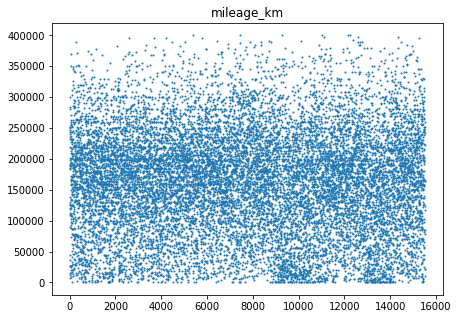

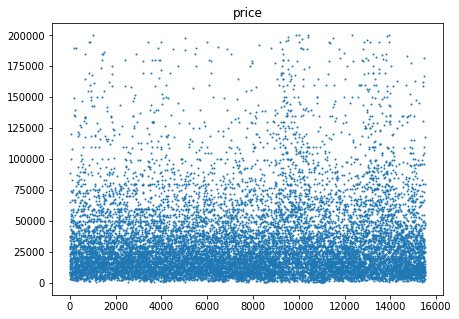

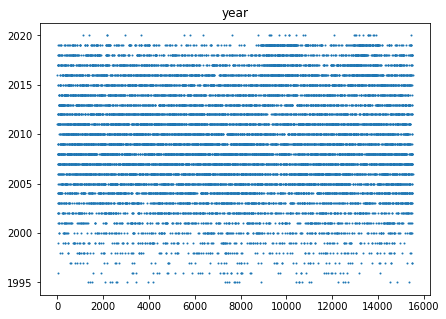

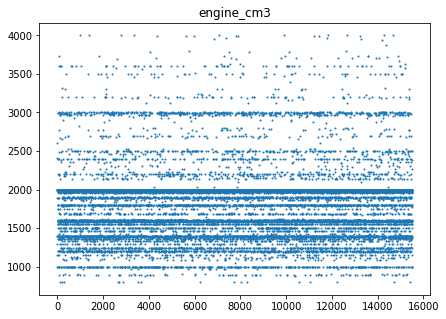

In [91]:
x.scatter_nox()

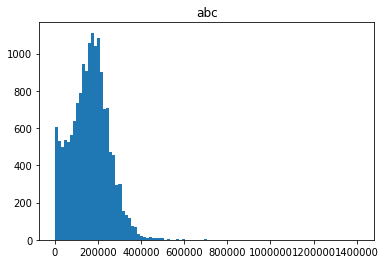

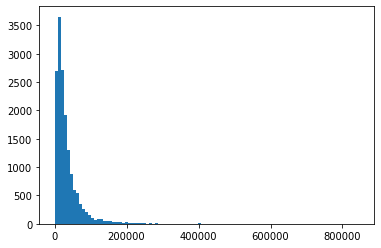

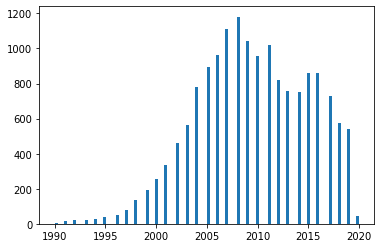

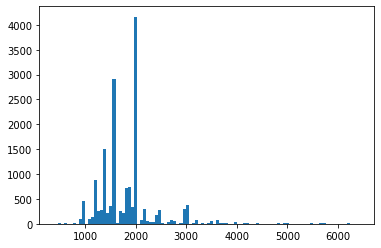

In [14]:
plt.hist(x.data['mileage_km'], bins = 100)
plt.title('abc')
plt.show()

plt.hist(x.data['price'],bins = 100)
plt.show()

plt.hist(x.data['year'], bins = 100)
plt.show()

plt.hist(x.data['engine_cm3'], bins = 100)
plt.show()

In [116]:
x.data[x.data['price']>1100000]

,ID,title,price,sub_title,mileage_km,year,engine_cm3,engine_type,city,province,negotiable
3172,6922,Subaru Forester,4999999,Subaru Forester,10200,2018,1995,Benzyna,Opatów,Świętokrzyskie,Do negocjacji
258,9639,Hyundai i20 1.2,17500000,NaN,48327,2011,1248,Benzyna,Warszawa,Mazowieckie,Do negocjacji


In [120]:
x.data[x.data['mileage_km']>1500000]

,ID,title,price,sub_title,mileage_km,year,engine_cm3,engine_type,city,province,negotiable
1437,1324,BMW X5 3.5d,52900,Bmw X5 M pakiet Pełna Opcja Niemcy Po Opłatach,26926000,2008,2993,Diesel,Małkinia Górna,Mazowieckie,NaN
3334,2979,Mercedes-Benz GLK 220,47999,"Pełen Serwis 211 tyś km, 205 KM 4x4 Stan BDB",2011000,2011,2143,Diesel,Krotoszyn,Wielkopolskie,Do negocjacji
538,4671,Mercedes-Benz GLK,33900,Glk 350cdi uszkodzony silnik,3140000,2010,2993,Diesel,Bojanowo,Wielkopolskie,Do negocjacji
1803,8905,Volkswagen Passat 2.0,14999,Volkswagen Passat B6 2.0 FSI benzyna 150 km 2006r,2160000,2006,1984,Benzyna,Grodzisk Mazowiecki,Mazowieckie,NaN
339,9719,Citroën C3 1.4,5600,Citroen C3 1.4 Benzyna/Gaz 100 za 14 PLN !!! K...,2460000,2003,1360,Benzyna+LPG,Stobierna,Podkarpackie,Do negocjacji
2362,11550,Volkswagen Passat 2.0,26500,"Volkswagen Passat B7 kombi ,2011 rok",3720207,2011,1968,Diesel,Grudziądz,Kujawsko-pomorskie,Do negocjacji
2645,11785,Peugeot 5008 1.6,29900,NaN,1890000,2014,1560,Diesel,Stargard Szczeciński,Zachodniopomorskie,NaN


In [124]:
x.data[x.data['year']<1990]

,ID,title,price,sub_title,mileage_km,year,engine_cm3,engine_type,city,province,negotiable
106,101,Opel Monza,19900,Monza 3.0 GSE manual szpera 16” BBS eta Beta I...,196870,1984,3000,Benzyna,Łódź,Łódzkie,NaN
479,446,BMW Seria 3,17900,cała w oryginale unikat,180000,1989,1795,Benzyna,Biała Podlaska,Lubelskie,NaN
1041,959,Rolls-Royce Silver Cloud,60270,NaN,112000,1965,6200,Benzyna,Kowalewo Pomorskie,Kujawsko-pomorskie,"Możliwość odliczenia VAT, Do negocjacji, Faktu..."
1252,1151,Ford Sierra 2.0,9999,"SIERRA 1,8 90 KM 1987 R. Salon Polska stan ide...",72000,1987,1954,Benzyna,Nysa,Opolskie,NaN
1839,1689,Mercedes-Benz W201 (190),6100,NaN,205000,1986,1977,Benzyna+LPG,Granowiec,Wielkopolskie,Do negocjacji
...,...,...,...,...,...,...,...,...,...,...,...
573,13649,Renault 4,21500,Glx,230000,1972,800,Benzyna,Lublin,Lubelskie,NaN
1000,14057,Volkswagen Transporter,23000,ZAREJESTROWANY stan bdb 5 osobowy,81700,1989,1570,Diesel,Toruń,Kujawsko-pomorskie,Do negocjacji
1237,14284,Mercedes-Benz,89000,Mercedes Kubuś 180,200,1955,1800,Benzyna,Sosnowiec,Śląskie,NaN
1373,14414,Mercedes-Benz Klasa C,22000,NaN,80000,1973,2000,Benzyna,Turek,Wielkopolskie,NaN


In [58]:
round(pd.DataFrame(
    data = x.data[['price', 'mileage_km', 'year', 'engine_cm3']].describe(),
    columns = x.data[['price', 'mileage_km', 'year', 'engine_cm3']].columns),2)

,price,mileage_km,year,engine_cm3
count,14645.00,14645.00,14645.00,14645.00
mean,36005.88,164651.53,2009.43,1847.69
std,155806.36,243440.03,5.96,637.42
min,250.00,0.00,1933.00,400.00
25%,11900.00,99223.00,2006.00,1496.00
50%,22000.00,164108.00,2009.00,1798.00
75%,40900.00,218060.00,2014.00,1997.00
max,17500000.00,26926000.00,2020.00,6417.00


,title,price,sub_title,mileage_km,year,engine_cm3,engine_type,city,province,negotiable
13,Honda CR-V,22500,NaN,190000,2007,Diesel,NaN,Brzostek,Podkarpackie,Do negocjacji
123,Tesla Model S 90,299997,europejska specyfikacja Autopilot supercharger...,79000,2017,Elektryczny,NaN,Zawiercie,Śląskie,"Możliwość odliczenia VAT, Faktura VAT"
157,Ford KA,13999,Super stan Full opcja klimatronik,130000,2010,Benzyna,NaN,Legnica,Dolnośląskie,NaN
158,BMW Seria 3,119000,M Pakiet,98888,2017,Diesel,NaN,Czermin,Wielkopolskie,NaN
160,Ford KA,13999,Super stan Full opcja klimatronik,130000,2010,Benzyna,NaN,Legnica,Dolnośląskie,NaN
...,...,...,...,...,...,...,...,...,...,...
4926,Volkswagen Golf,89000,"Comfortline, 2.0 TDI BMT 150KM, manualna, NAWI...",5,2019,Diesel,NaN,Poznań,Wielkopolskie,Faktura VAT
4938,Renault Zoe,96900,"Life, FV-23%, gwarancja",9384,2018,Elektryczny,NaN,Jawornik,Małopolskie,Faktura VAT
4952,Renault Megane,18500,Xenon Panoramadach Navi,160125,2010,Diesel,NaN,Czarnków,Wielkopolskie,NaN
4953,Renault Zoe,96900,"Life, FV-23%, gwarancja",11466,2018,Elektryczny,NaN,Jawornik,Małopolskie,Faktura VAT


In [161]:
x.data.isnull().sum()

title             0
price             0
sub_title      1159
mileage_km        0
year              0
engine_cm3        0
engine_type     418
city              1
province          0
negotiable     5306
dtype: int64

In [15]:
data = pd.read_csv('run_results_21-04-2020.csv')

In [38]:
data = ReadAndPreprocess(df)

AttributeError: 'float' object has no attribute 'replace'

In [52]:
df = pd.read_csv('data/run_results_21-04-2020.csv')
df.head()

,title_name,title_price,title_sub_title,title_mileage,title_year,title_engine_l,title_engine_type,title_localization_1,title_localization_2,title_negotiable
0,Volkswagen Golf,14 900,Sprzedam 1.9 ARL TURBO MOC 300 KM . Zarejestro...,160 000 km,2008,1 900 cm3,Diesel,Pęzino,(Zachodniopomorskie),Do negocjacji
1,BMW Seria 4 420d,99 000,BMW Seria 4,88 000 km,2015,1 995 cm3,Diesel,Pszczyna,(Śląskie),NaN
2,Audi A4,28 900,1.8 T tylko 102000 tyś. km. przebiegu grzane f...,102 000 km,2009,1 800 cm3,Benzyna,Góra,(Dolnośląskie),Do negocjacji
3,Opel Zafira,54 900,1.4 Turbo 120 KM ! Klimatronic ! Naviagacja !,88 500 km,2016,1 364 cm3,Benzyna,Baranów,(Lubelskie),NaN
4,Škoda Fabia 1.4,6 900,"1,4 benzyna UWAGA niski przebieg",75 000 km,2001,1 397 cm3,Benzyna,Pułtusk,(Mazowieckie),Do negocjacji


In [53]:
df2 = pd.read_csv('data/run_results_25-04_2020.csv')
df2.head()

,title_name,title_price,title_sub_title,title_mileage,title_year,title_engine_l,title_engine_type,title_localization_1,title_localization_2,title_negotiable
0,Renault Captur,52 700,Gwarancja-Full Wersja-Black Deasing-Navi-Kamer...,15 500 km,2019,1 200 cm3,Benzyna,Gniezno,(Wielkopolskie),Do negocjacji
1,Renault Trafic,24 900,Vivaro 2.5 DCi 135KM 23000km Klimatyzacja Tył ...,230 000 km,2005,2 463 cm3,Diesel,Jarocin,(Wielkopolskie),NaN
2,Audi A4 Cabriolet,8 000,Audi A4B6 3.0 Bez+Gaz Sprzedam/Zamienie,235 000 km,2004,2 976 cm3,Benzyna+LPG,Tczew,(Pomorskie),Do negocjacji
3,BMW Seria 5,45 000,opis samochodu w zdjęciach,304 000 km,2011,Diesel,NaN,Psary,(Śląskie),Do negocjacji
4,Seat Altea,14 900,"2005rok 1,9TDI 105KM",171 505 km,2005,1 896 cm3,Diesel,Kalisz,(Wielkopolskie),Do negocjacji


In [54]:
df3 = pd.read_csv('data/run_results_26-04-2020.csv')
df3.head()

,title_name,title_price,title_mileage,title_year,title_engine_l,title_engine_type,title_localization_1,title_localization_2,title_negotiable,title_sub_title
0,Volkswagen Beetle 2.0,42 900,64 000 km,2012,1 984 cm3,Benzyna,Borkowo Kościelne,(Mazowieckie),Do negocjacji,NaN
1,Škoda Fabia 1.2,6 990,188 000 km,2006,1 198 cm3,Benzyna,Niegosław,(Lubuskie),Do negocjacji,benzyna 1.2 / klima / lift
2,Mazda 3 1.6,8 000,213 169 km,2005,1 598 cm3,Benzyna,Warszawa,(Mazowieckie),Do negocjacji,Mazda 3 I Exclusive 2005 1.6 benzyna 105KM
3,Audi A6 3.0,21 900,300 000 km,2005,2 967 cm3,Diesel,Kamień Pomorski,(Zachodniopomorskie),Do negocjacji,3.0 TDI S LINE Bose Super Stan Quattro Szyberdach
4,Opel Astra,9 500,216 000 km,2004,1 364 cm3,Benzyna,Iłowa,(Lubuskie),Do negocjacji,*H*1.4*Benzyna*Klimatyzacja*Bezwypadkowy*Orygi...


In [84]:
x.df_head()